In [1]:
import os, json, torch, random
import numpy as np
from monai import transforms
from monai.data import DataLoader, DistributedSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from monai.networks.nets.swin_unetr import SwinUNETR
from monai.inferers import sliding_window_inference
from functools import partial
import matplotlib.pyplot as plt
from models.SuperFormer import SuperFormer
import nibabel as nib

In [2]:
class MRIDataset(Dataset):
    def downsample_mri_kspace(self, mri_image, downsampling_factor):
        """
        Downsamples an MRI image using k-space zero-filling.
        """
        # Get the image data and affine transformation
        data = mri_image[0]

        # Get the spatial dimensions
        spatial_dims = data.shape[:len(downsampling_factor)]
        num_spatial_dims = len(spatial_dims)

        # Check if the downsampling factor is valid
        if len(downsampling_factor) != num_spatial_dims:
            raise ValueError(f"Downsampling factor length ({len(downsampling_factor)}) must match the number of spatial dimensions ({num_spatial_dims}).")
        for factor in downsampling_factor:
            if not isinstance(factor, int) or factor < 1:
                raise ValueError("Downsampling factors must be positive integers.")

        # Perform k-space transform
        k_space = np.fft.fftn(data, axes=range(num_spatial_dims))
        k_space_shifted = np.fft.fftshift(k_space, axes=range(num_spatial_dims))

        # Create a new k-space array with zero-filling
        new_k_space_shape = list(k_space_shifted.shape)

        # Determine the central portion to keep in k-space
        start_indices = []
        end_indices = []
        for i in range(num_spatial_dims):
            center = spatial_dims[i] // 2
            half_kept = (spatial_dims[i] // downsampling_factor[i]) // 2
            start_indices.append(center - half_kept)
            end_indices.append(center + (spatial_dims[i] // downsampling_factor[i]) - half_kept)
            new_k_space_shape[i] = spatial_dims[i] // downsampling_factor[i]

        # Place the central portion of the original k-space into the new (larger) array
        slices = tuple(slice(start, end) for start, end in zip(start_indices, end_indices))
        # downsampled_k_space_shifted[slices] = k_space_shifted[slices]
        downsampled_k_space_shifted = k_space_shifted[slices]

        # Inverse k-space transform to get the downsampled image
        downsampled_k_space = np.fft.ifftshift(downsampled_k_space_shifted, axes=range(num_spatial_dims))
        downsampled_data = np.fft.ifftn(downsampled_k_space, axes=range(num_spatial_dims)).real
        downsampled_data = downsampled_data[np.newaxis, ...]  # Add a new axis to match the original shape

        return downsampled_data

    def __init__(self, image_paths, type, resample_factors):
        self.image_paths = image_paths
        self.resample_factors = resample_factors
        self.train_transform_1 = transforms.Compose([
            transforms.CopyItemsd(keys=[type], names=['path']),
            transforms.LoadImaged(keys=[type]),
            transforms.CopyItemsd(keys=[type], names=['image']),
            transforms.DeleteItemsd(keys=[type]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.EnsureTyped(keys=["image"]),
            transforms.Orientationd(keys=["image"], axcodes="RAS"),
            transforms.ScaleIntensityRangePercentilesd(keys=["image"], lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),
            transforms.Spacingd(keys=['image'],pixdim=(1,1,1),mode="nearest"),
            transforms.ResizeWithPadOrCropd(keys=['image'],spatial_size=(240,240,160)),
            transforms.CopyItemsd(keys=['image'], names=['hi_res','low_res'], times=2),
            transforms.DeleteItemsd(keys=['image']),])
        self.train_transform_2 = transforms.Compose([
            transforms.Resized(keys=["low_res"], spatial_size=(240,240,160), mode="nearest"),
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        data = self.image_paths[idx]
        transformed_data = self.train_transform_1(data)
        # transformed_data['low_res'] = self.downsample_mri_kspace(transformed_data['low_res'],self.resample_factors)
        # transformed_data = self.train_transform_2(transformed_data)
        return transformed_data

In [3]:
with open('json/short_list.json') as f:
    test_pair = json.load(f)
    print(len(test_pair))
random.seed(0)
random.shuffle(test_pair)
test_pair = test_pair

100


In [4]:
test_pair = [{
        "fl": "/working/Data/Images/Cerebro_data/nifti_fl_bet/t10119_fl_bet.nii.gz"
    },
    {
        "fl": "/working/Data/Images/Cerebro_data/nifti_fl_bet/t16262_fl_bet.nii.gz"
    },]

In [5]:
down_sample = 4
test_ds = MRIDataset(test_pair,type='fl', resample_factors = (1, 1, 4))
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=2, persistent_workers=True)#'path', 'hi_res', 'low_res'

In [6]:
model = SuperFormer(upscale=1,
                   patch_size = 2,
                   in_chans=1,
                   img_size=64,
                   window_size=8,
                   img_range=1.0,
                   depths=[6, 6, 6],
                   embed_dim=240,
                   num_heads=[6, 6, 6],
                   mlp_ratio=2,
                   upsampler=None,
                   resi_connection="1conv",
                   ape=False, 
                   rpb=True,
                   output_type = "direct",
                   num_feat = 126)
# model.load_state_dict(torch.load('./checkpoint_superformer/pytorch_model.bin',weights_only=True))
model.load_state_dict(torch.load('/working/Project/Sup_Res/checkpoint_superformer/superformer_4modalities.bin',weights_only=True))
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[64, 64, 64],
    sw_batch_size=20,
    predictor=model,
    overlap=0.6,
)

In [7]:
high_res_folder = './Infer/high_res'
low_res_folder = './Infer/low_res'
recon_folder = './Infer/recon'
if not os.path.exists(high_res_folder):
    os.makedirs(high_res_folder)
if not os.path.exists(low_res_folder):
    os.makedirs(low_res_folder)
if not os.path.exists(recon_folder):
    os.makedirs(recon_folder)
output_list = []
with torch.no_grad():
    with torch.autocast(device_type="cuda" , dtype=torch.bfloat16):
        for batch_data in tqdm(test_loader):
            paths = batch_data["path"]
            image = batch_data["hi_res"].to(device)
            low_res = batch_data["low_res"].to(device)
            output = model_inferer(low_res)
            output = model_inferer(output)
            high_res = image.cpu().float().numpy()
            low_res = low_res.cpu().float().numpy()
            recon = output.cpu().float().numpy()
            B,C,H,W,D = high_res.shape
            for i in range(B):
                path = paths[i]
                basename = os.path.basename(path)
                tnum = path.split('/')[-1].split('_')[0]
                low_res_image = low_res[i,0,:,:,:]
                recon_image = recon[i,0,:,:,:]
                high_res_image = high_res[i,0,:,:,:]
                
                raw_nib = nib.load(path)
                spacing = raw_nib.header['pixdim'][1:4]
                nib_size = raw_nib.shape
                affine = np.eye(4)
                affine[:3,:3] = np.diag(spacing)
                transfrom_infer = transforms.Compose([
                    transforms.EnsureChannelFirst(channel_dim=0),
                    transforms.Spacing(pixdim=spacing,mode='bilinear'),
                    transforms.ResizeWithPadOrCrop(spatial_size=nib_size),
                    ])
                low_res_image = transfrom_infer(low_res_image[np.newaxis,:,:,:].copy())[0].numpy()
                recon_image = transfrom_infer(recon_image[np.newaxis,:,:,:].copy())[0].numpy()
                high_res_image = transfrom_infer(high_res_image[np.newaxis,:,:,:].copy())[0].numpy()

                low_res_nib = nib.Nifti1Image(low_res_image.astype(np.float32),affine)
                recon_nib = nib.Nifti1Image(recon_image.astype(np.float32),affine)
                high_res_nib = nib.Nifti1Image(high_res_image.astype(np.float32),affine)
                hig_path = f'{high_res_folder}/{tnum}'
                os.makedirs(hig_path,exist_ok=True)
                low_path = f'{low_res_folder}_{down_sample}/{tnum}'
                os.makedirs(low_path,exist_ok=True)
                recon_path = f'{recon_folder}_{down_sample}/{tnum}'
                os.makedirs(recon_path,exist_ok=True)

                nib.save(high_res_nib,os.path.join(hig_path,basename))
                nib.save(low_res_nib,os.path.join(low_path,basename))
                nib.save(recon_nib,os.path.join(recon_path,basename))
                output_list.append({'high_res':os.path.join(hig_path,basename),'low_res':os.path.join(low_path,basename),'recon':os.path.join(recon_path,basename)})
            # break

100%|██████████| 1/1 [09:08<00:00, 548.17s/it]


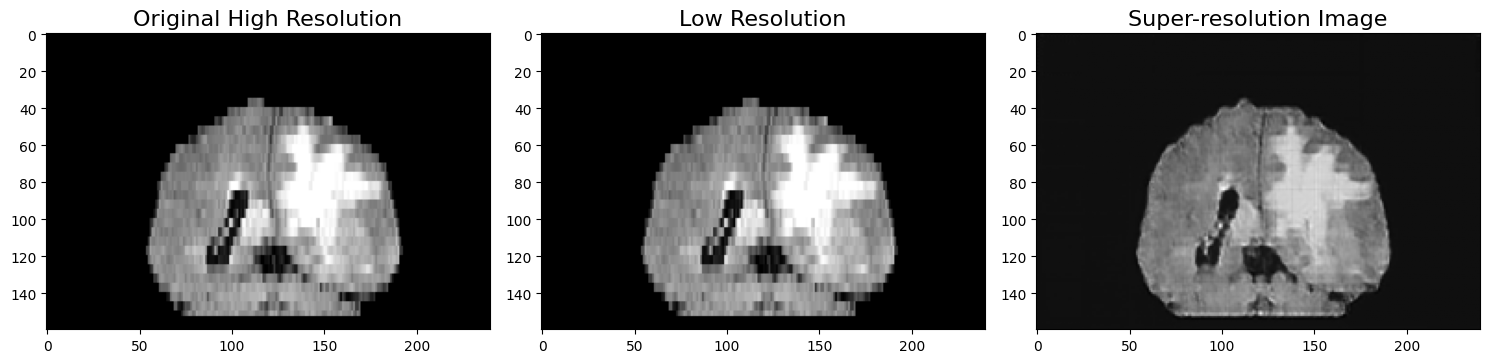

In [12]:
idx = 0
slice = 100
image_ = high_res[idx][0]
low_res_ = low_res[idx][0]
recon_ = recon[idx][0]
plt.figure(figsize=(15,15))

plt.subplot(131)
image_ = np.rot90(image_[:, slice, :])
plt.imshow(image_, cmap='gray')
plt.title('Original High Resolution', fontsize=16)

plt.subplot(132)
low_res_ = np.rot90(low_res_[:, slice, :])
plt.imshow(low_res_, cmap='gray')
plt.title('Low Resolution', fontsize=16)

plt.subplot(133)
recon_ = np.rot90(recon_[:, slice, :])
plt.imshow(recon_, cmap='gray')
plt.title('Super-resolution Image', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from glob import glob

def compute_psnr_ssim(lr_image: np.ndarray, hr_image: np.ndarray):
    psnr_value = psnr(hr_image, lr_image, data_range=hr_image.max() - hr_image.min())
    ssim_value = ssim(hr_image, lr_image, data_range=hr_image.max() - hr_image.min(), multichannel=True)
    return psnr_value, ssim_value

def compute_score_tnum_(tnum, down_sample=5, type='t1c'):
    high_res_path = f'/data/Sup_Res/high_res/{tnum}'
    low_res_path = f'/data/Sup_Res/low_res_{down_sample}/{tnum}'
    recon_path = f'/data/Sup_Res/recon_{down_sample}/{tnum}'
    print(f'{high_res_path}/*{type}_bet.nii.gz')
    high_res = glob(f'{high_res_path}/*{type}_bet.nii.gz')[0]
    low_res = glob(f'{low_res_path}/*{type}_bet.nii.gz')[0]
    recon = glob(f'{recon_path}/*{type}_bet.nii.gz')[0]
    high_res_nib = nib.load(high_res)
    high_res_image = high_res_nib.get_fdata()
    low_res_nib = nib.load(low_res)
    low_res_image = low_res_nib.get_fdata()
    recon_nib = nib.load(recon)
    recon_image = recon_nib.get_fdata()
    psnr_value, ssim_value = compute_psnr_ssim(low_res_image, high_res_image)
    low_score = {'psnr':psnr_value, 'ssim':ssim_value}
    psnr_value, ssim_value = compute_psnr_ssim(recon_image, high_res_image)
    recon_score = {'psnr':psnr_value, 'ssim':ssim_value}
    return low_score, recon_score

In [ ]:
def compute_score_tnum(high_path, low_path):
    high_res_nib = nib.load(high_path)
    high_res_image = high_res_nib.get_fdata()
    low_res_nib = nib.load(low_path)
    low_res_image = low_res_nib.get_fdata()

    psnr_value, ssim_value = compute_psnr_ssim(low_res_image, high_res_image)
    return psnr_value, ssim_value

In [ ]:
def make_downsample(input_path, output_path, down_sample):
    nifti_img = nib.load(input_path)
    data = nifti_img.get_fdata()
    affine = nifti_img.affine.copy()

    # 选择每 5 层中的 1 层
    downsampled_data = data[:, :, ::down_sample]

    # 调整 affine 矩阵，使 Z 轴间距变为原来的 5 倍
    affine[2, :3] *= down_sample

    # 创建新的 NIfTI 图像并保存
    new_nifti = nib.Nifti1Image(downsampled_data, affine)
    nib.save(new_nifti, output_path)

In [ ]:
from scipy.ndimage import zoom
def process_nifti(input_path, output_path, downsample_factor=5):
    # 加载NIfTI文件
    img = nib.load(input_path)
    data = img.get_fdata()
    
    # 获取原始维度
    orig_shape = data.shape
    
    # 沿z轴每5层取1层
    z_downsampled = data[:, :, ::downsample_factor]
    
    # 计算需要放大的倍数以恢复原始z轴大小
    zoom_factor = orig_shape[2] / z_downsampled.shape[2]
    
    # 使用最近邻插值恢复到原始大小
    # 对x,y轴保持不变(zoom_factor=1)，对z轴进行插值
    resized_data = zoom(z_downsampled, 
                       (1, 1, zoom_factor), 
                       order=0)  # order=0表示最近邻插值
    
    # 确保输出维度与原始维度相同
    if resized_data.shape != orig_shape:
        # 如果有微小差异，进行裁剪或填充
        resized_data = resized_data[:orig_shape[0], 
                                 :orig_shape[1], 
                                 :orig_shape[2]]
    
    # 创建新的NIfTI图像，保持原始的头信息
    new_img = nib.Nifti1Image(resized_data, img.affine, img.header)
    
    # 保存到新的文件
    nib.save(new_img, output_path)
    print(f"已保存处理后的文件到: {output_path}")

In [ ]:
down_sample = 3
for input_path in glob('/data/Sup_Res/high_res/t*/*t1c_bet.nii.gz'):
    output_path = input_path.replace('t1c_bet',f't1c_bet_{down_sample}')
    process_nifti(input_path, output_path, down_sample)
down_sample = 5
for input_path in glob('/data/Sup_Res/high_res/t*/*fl_bet.nii.gz'):
    output_path = input_path.replace('fl_bet',f'fl_bet_{down_sample}')
    process_nifti(input_path, output_path, down_sample)
down_sample = 5
for input_path in glob('/data/Sup_Res/high_res/t*/*t1c_bet.nii.gz'):
    output_path = input_path.replace('t1c_bet',f't1c_bet_{down_sample}')
    process_nifti(input_path, output_path, down_sample)

In [ ]:
import pickle

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet_3.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('Flair downsample 3')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('flair_downsample_3.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet_5.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('Flair downsample 5')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('flair_downsample_5.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet_3.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('T1c downsample 3')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('t1c_downsample_3.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet_5.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('T1c downsample 5')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('t1c_downsample_5.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/low_res_5/{tnum}/*t1c_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('T1c bicubic 5')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('t1c_bicubic_5.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/low_res_3/{tnum}/*t1c_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('T1c bicubic 3')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('t1c_bicubic_3.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/low_res_5/{tnum}/*fl_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('Flair bicubic 5')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('fl_bicubic_5.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/low_res_3/{tnum}/*fl_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('Flair bicubic 3')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('fl_bicubic_3.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/recon_5/{tnum}/*t1c_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('T1c recon 5')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('t1c_recon_5.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*t1c_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/recon_3/{tnum}/*t1c_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('T1c recon 3')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('t1c_recon_3.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/recon_5/{tnum}/*fl_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('Flair recon 5')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('fl_recon_5.pkl','wb'))

In [ ]:
psnr_value_list = []
ssim_value_list = []
for tnum in tqdm(os.listdir('/data/Sup_Res/high_res')):
    # print(tnum)
    high_res_path = glob(f'/data/Sup_Res/high_res/{tnum}/*fl_bet.nii.gz')[0]
    low_res_path = glob(f'/data/Sup_Res/recon_3/{tnum}/*fl_bet.nii.gz')[0]
    # print(high_res_path, low_res_path)
    psnr_value, ssim_value = compute_score_tnum(high_res_path, low_res_path)
    # print(f'low_res: {psnr_value}, {ssim_value}')
    psnr_value_list.append(psnr_value)
    ssim_value_list.append(ssim_value)
print('Flair recon 3')
print(np.mean(psnr_value_list), np.mean(ssim_value_list))
print(np.std(psnr_value_list), np.std(ssim_value_list))
score_data = {'psnr':psnr_value_list, 'ssim':ssim_value_list}
pickle.dump(score_data,open('fl_recon_3.pkl','wb'))